# 💼 Job Recommender

## 📌 Introduction

The job recommender system suggests relevant jobs based on various criteria to enhance user experience and job discovery.

### 🔍 Recommendation Criteria:
- **Location-based Trends**: Identify popular locations among job seekers and creators.  
- **Similar Job Titles/Descriptions**: Recommend jobs based on job title and description similarity.  
- **User Profile Matching**: Suggest jobs based on profiles of similar users.  


##  🖥️  CODE START

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast 
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import zipfile


import warnings; warnings.simplefilter('ignore')

### Packages we are importing and why we would use them:

* **pyplot** from matplotlib: To create visualizations and plots.
* **seaborn**: To create histograms and advanced statistical charts.
* **pandas**: For handling and manipulating data using DataFrames.
* **numpy**: For numerical computations and array operations.
* **ast**: Used to safely evaluate and parse Python literals, such as converting strings to lists or dictionaries.
* **scipy**: Provides mathematical and scientific computing functions, often used for optimization, statistics, and linear algebra.
* **sklearn**:

    - **TfidfVectorizer**: Converts text data into TF-IDF vectors, which quantify the importance of words in a document while reducing the impact of commonly occurring words.
    - **CountVectorizer**: Converts text documents into a matrix of token counts, useful for simple frequency-based text analysis.
    - **linear_kernel**: Computes the linear kernel (dot product) between vectors, often used for similarity measures in recommendation systems.
    - **cosine_similarity**: Measures the cosine of the angle between two vectors, commonly used to determine text similarity in recommendation systems.


In [2]:
zip_file_path = "/kaggle/input/job-recommendation/jobs.zip" 

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:

    zip_ref.extractall()

**We use the zipfile module previously imported to  extract the jobs.tsv file from the input dataset since it was present inside of a zip file and then we will access it from the working directory.**

In [3]:
apps = pd.read_csv('/kaggle/input/job-recommendation/apps.tsv', delimiter='\t',encoding='utf-8')
user_history = pd.read_csv('/kaggle/input/job-recommendation/user_history.tsv', delimiter='\t',encoding='utf-8')
jobs = pd.read_csv('/kaggle/working/jobs.tsv', delimiter='\t',encoding='utf-8', on_bad_lines="skip")
users = pd.read_csv('/kaggle/input/job-recommendation/users.tsv' ,delimiter='\t',encoding='utf-8')
test_users = pd.read_csv('/kaggle/input/job-recommendation/test_users.tsv', delimiter='\t',encoding='utf-8')

All the data is now loaded in apps [] , user_history [], jobs[], users[], test_users[]

In [4]:
apps.head()

,UserID,WindowID,Split,ApplicationDate,JobID
0,47,1,Train,2012-04-04 15:56:23.537,169528
1,47,1,Train,2012-04-06 01:03:00.003,284009
2,47,1,Train,2012-04-05 02:40:27.753,2121
3,47,1,Train,2012-04-05 02:37:02.673,848187
4,47,1,Train,2012-04-05 22:44:06.653,733748


In [5]:
shape=apps.shape
columns=apps.columns
print(shape)
print(columns)

(1603111, 5)
Index(['UserID', 'WindowID', 'Split', 'ApplicationDate', 'JobID'], dtype='object')


In [6]:
user_history.head()

,UserID,WindowID,Split,Sequence,JobTitle
0,47,1,Train,1,National Space Communication Programs-Special ...
1,47,1,Train,2,Detention Officer
2,47,1,Train,3,"Passenger Screener, TSA"
3,72,1,Train,1,"Lecturer, Department of Anthropology"
4,72,1,Train,2,Student Assistant


In [7]:
shape=user_history.shape
columns=user_history.columns
print(shape)
print(columns)

(1753901, 5)
Index(['UserID', 'WindowID', 'Split', 'Sequence', 'JobTitle'], dtype='object')


In [8]:
jobs.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US,20531,2012-03-07 13:17:01.643,2012-04-06 23:59:59
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US,28217,2012-03-21 02:03:44.137,2012-04-20 23:59:59
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US,32792,2012-03-02 16:36:55.447,2012-04-01 23:59:59
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:10.077,2012-04-02 23:59:59
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:11.88,2012-04-02 23:59:59


In [9]:
shape=jobs.shape
columns=jobs.columns
print(shape)
print(columns)

(1091923, 11)
Index(['JobID', 'WindowID', 'Title', 'Description', 'Requirements', 'City',
       'State', 'Country', 'Zip5', 'StartDate', 'EndDate'],
      dtype='object')


In [10]:
users.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [11]:
shape=users.shape
columns=users.columns
print(shape)
print(columns)

(389708, 15)
Index(['UserID', 'WindowID', 'Split', 'City', 'State', 'Country', 'ZipCode',
       'DegreeType', 'Major', 'GraduationDate', 'WorkHistoryCount',
       'TotalYearsExperience', 'CurrentlyEmployed', 'ManagedOthers',
       'ManagedHowMany'],
      dtype='object')


In [12]:
test_users.head()

,UserID,WindowID
0,767,1
1,769,1
2,861,1
3,1006,1
4,1192,1


In [13]:
shape=test_users.shape
columns=test_users.columns
print(shape)
print(columns)

(22838, 2)
Index(['UserID', 'WindowID'], dtype='object')


## 📊 EDA and Data Cleaning

### 🔍 Understanding the Data

From our extracted columns, we found **three** data frames that contain the `'Split'` attribute. This means the data is categorized as either **training** or **testing**, requiring us to create separate data frames accordingly.

### 📂 Identified Data Frames:
1. **apps**  
2. **user_history**  
3. **users**  


In [14]:
apps_training=apps.loc[apps['Split']=='Train']
apps_testing=apps.loc[apps['Split']=='Test']

In [15]:
user_history_training=user_history.loc[user_history['Split']=='Train']
user_history_testing=user_history.loc[user_history['Split']=='Test']

In [16]:
users_training=users.loc[users['Split']=='Train']
users_testing=users.loc[users['Split']=='Test']

In [17]:
jobs.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                             ascending=False).head()

,Country,Locationwise
59,US,1090462
4,AF,560
19,CZ,193
40,MX,93
52,TR,81


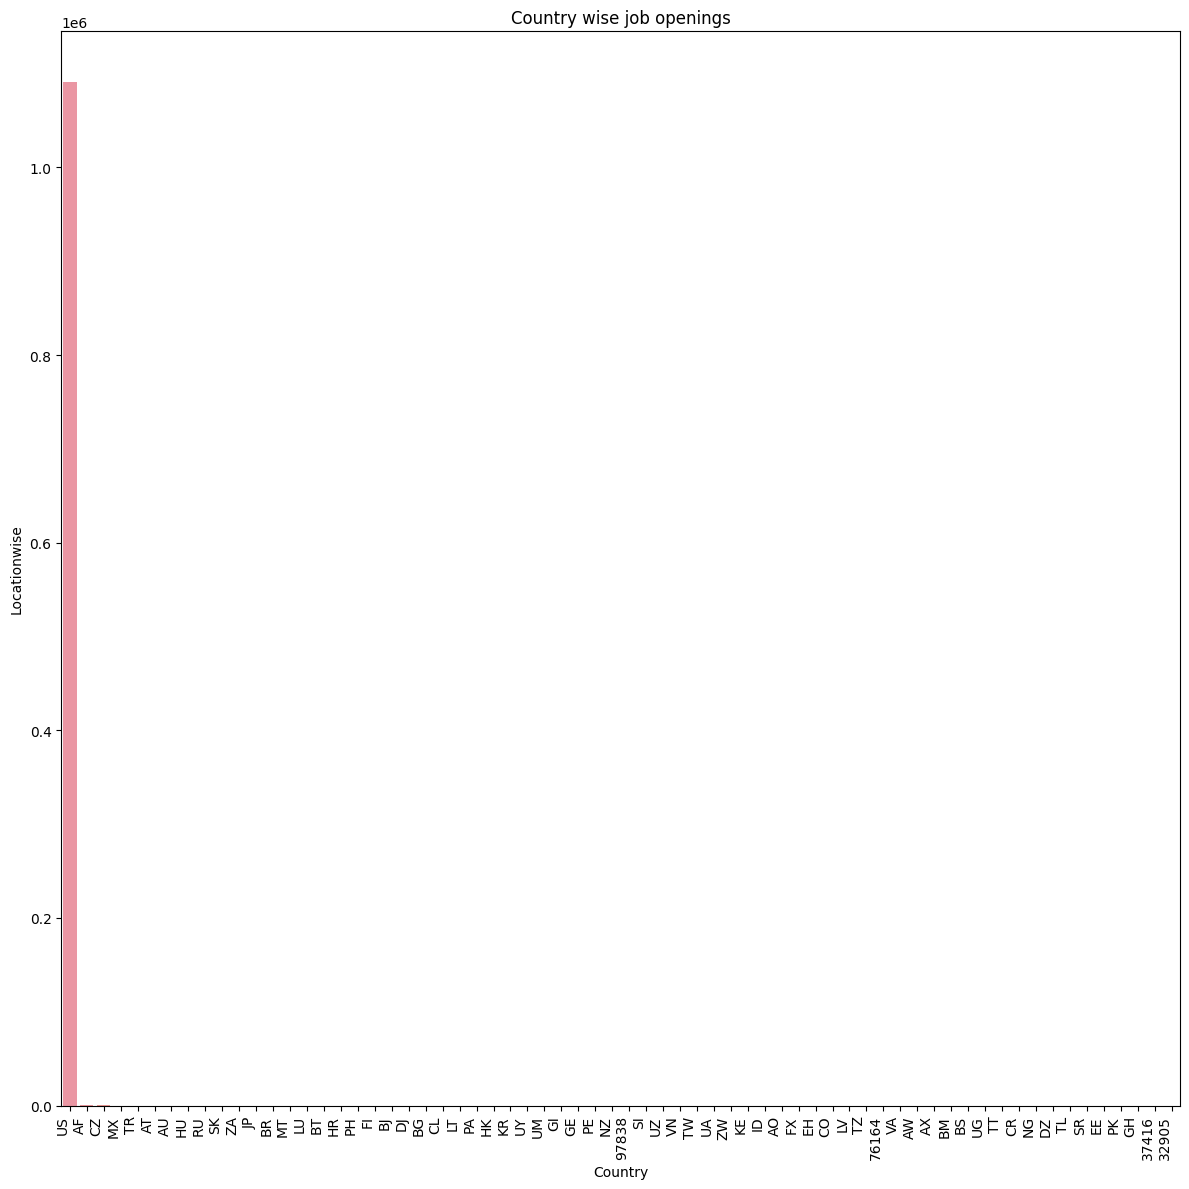

In [18]:
Country_wise_job = jobs.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                             ascending=False)
plt.figure(figsize=(12,12))
ax = sns.barplot(x="Country", y="Locationwise", data=Country_wise_job)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('Country wise job openings')
plt.tight_layout()
plt.show()

This shows that US has the most job postings with other countries having negligible amount so it would be beneficial to not consider them at all for the data

In [20]:
jobs_US=jobs.loc[jobs['Country']=='US']
jobs_US[['City','State','Country']]

,City,State,Country
0,Washington,DC,US
1,Charlotte,NC,US
2,Winter Park,FL,US
3,Orlando,FL,US
4,Orlando,FL,US
...,...,...,...
1091918,Amsterdam,NY,US
1091919,Birmingham,AL,US
1091920,Carthage,MS,US
1091921,Warren,MI,US


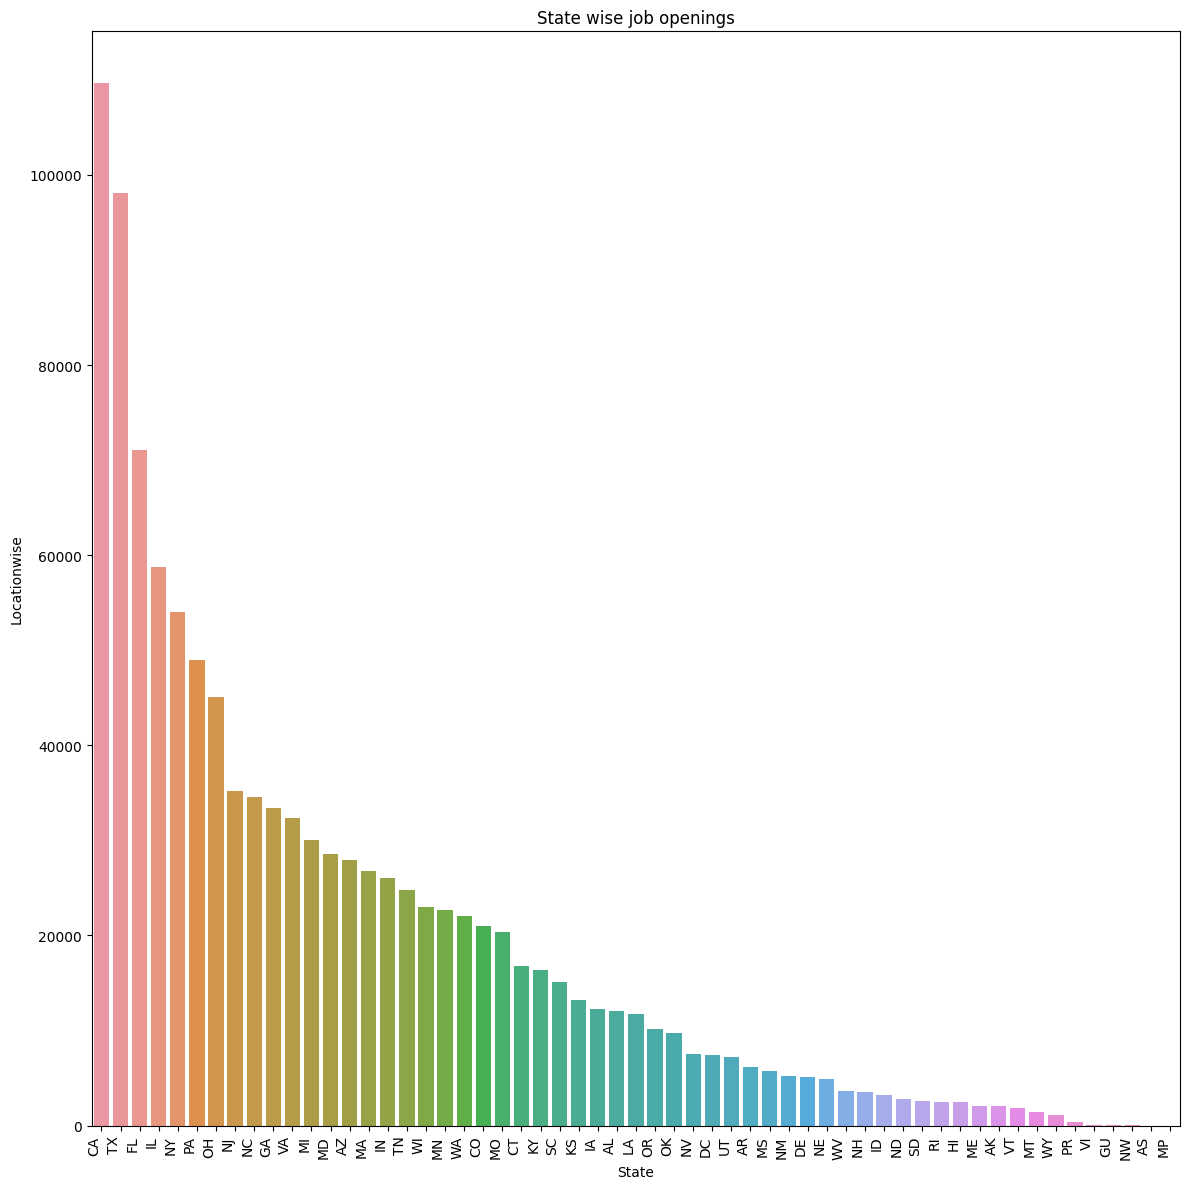

In [23]:
State_wise_job_US = jobs_US.groupby(['State']).size().reset_index(name=
                                                                       'Locationwise'
                                                                      ).sort_values('Locationwise',ascending=False)
plt.figure(figsize=(12,12))
ax = sns.barplot(x="State", y="Locationwise",data=State_wise_job_US)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job openings')
plt.tight_layout()
plt.show()

This shows the per state distribution of Jobs in US. Clearly California ranks the highest.

In [26]:
City_wise_location = jobs_US.groupby(['City']).size().reset_index(
    name='Locationwise').sort_values('Locationwise',ascending=False)
# Also given that there would be a lot of ciities with minimal number of jobs, lets for the sake of data only consider the cities with more than 15 job posting.

City_wise_location = City_wise_location.loc[City_wise_location['Locationwise']>=15]
City_wise_location

,City,Locationwise
4564,Houston,19323
6809,New York,18402
1782,Chicago,17806
2351,Dallas,13202
408,Atlanta,12365
...,...,...
49,Adel,15
3104,Endwell,15
311,Arbutus,15
5936,Mascoutah,15


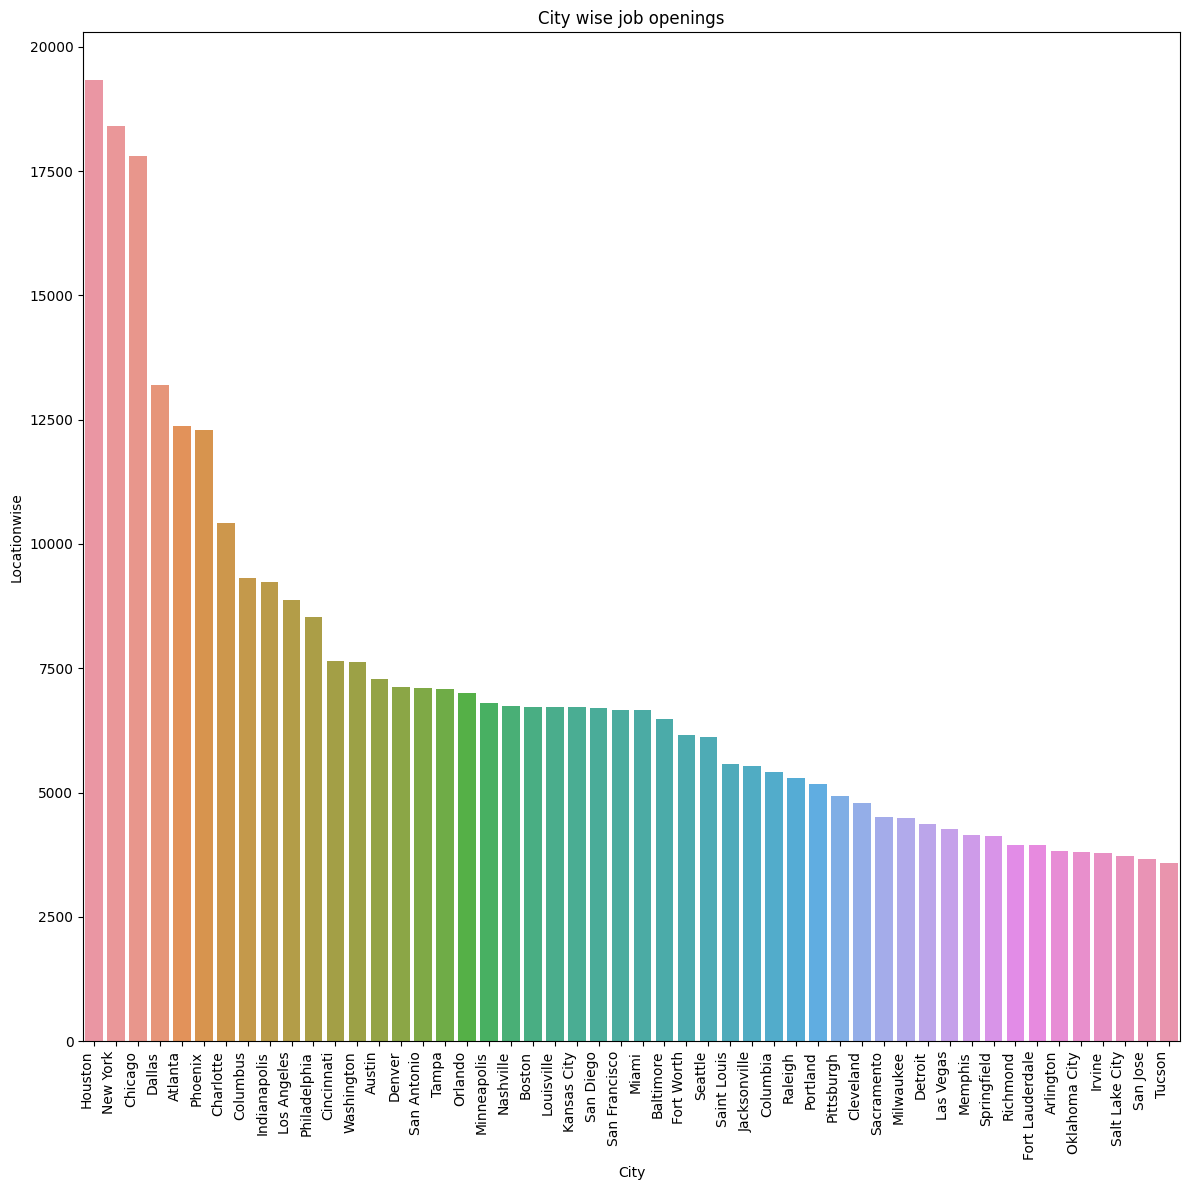

In [28]:
#Plot
plt.figure(figsize=(12,12))
ax = sns.barplot(x="City", y="Locationwise",data=City_wise_location.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('City wise job openings')
plt.tight_layout()
plt.show()

In [29]:
user_training_US = users_training.loc[users_training['Country']=='US']
user_training_US_state_wise = user_training_US.groupby(['State']).size().reset_index(
    name='Locationwise_state').sort_values('Locationwise_state',ascending=False)
user_training_US = user_training_US_state_wise.loc[user_training_US_state_wise['Locationwise_state']>=15]

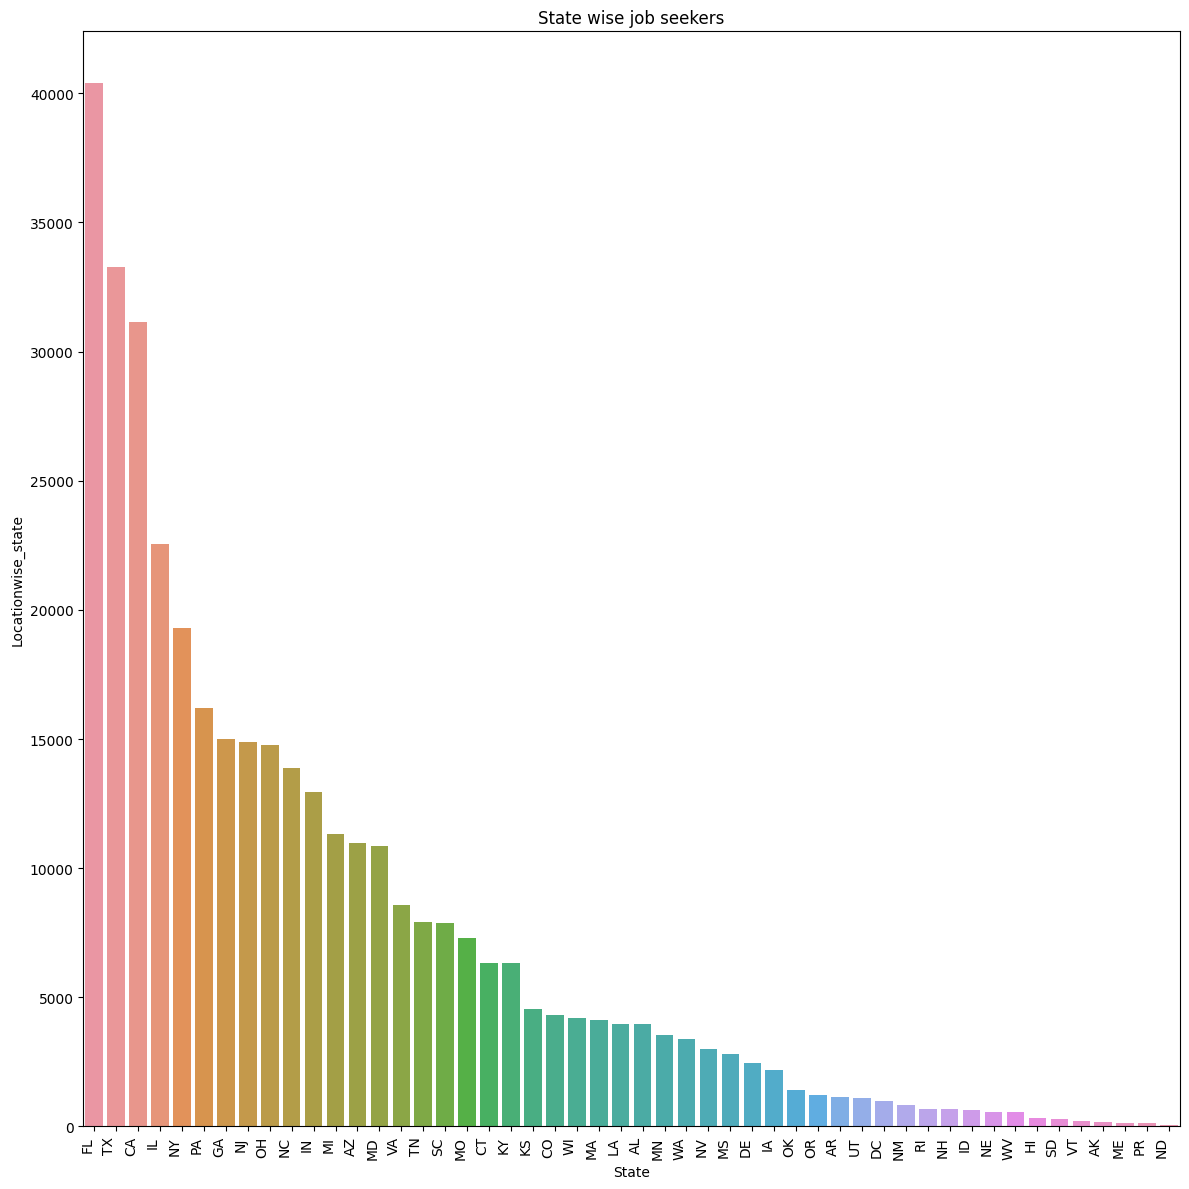

In [30]:
#PLOT
plt.figure(figsize=(12,12))
ax = sns.barplot(x="State", y="Locationwise_state",data=user_training_US.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job seekers')
plt.tight_layout()
plt.show()

This marks the end of Data analysis and Visualisation, now lets get to recommendation system.

## 📌 Recommendation System

Our recommendation system suggests relevant job opportunities based on **user profiles and job descriptions**. We use **text-based similarity** techniques to match users with jobs.

### **Approach Used**
We implemented two main approaches:

1. **Content-Based Filtering**
   - Uses **TF-IDF vectorization** to analyze job descriptions.
   - Measures **cosine similarity** to recommend similar jobs based on a given job title.

2. **User-Based Filtering**
   - Focuses on users’ **Degree, Major, and Experience**.
   - Creates a **TF-IDF matrix** for user profiles.
   - Recommends jobs based on **similar user profiles**.

### **Content-Based Filtering**

In [32]:
jobs_US

,JobID,WindowID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US,20531,2012-03-07 13:17:01.643,2012-04-06 23:59:59
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US,28217,2012-03-21 02:03:44.137,2012-04-20 23:59:59
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US,32792,2012-03-02 16:36:55.447,2012-04-01 23:59:59
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:10.077,2012-04-02 23:59:59
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:11.88,2012-04-02 23:59:59
...,...,...,...,...,...,...,...,...,...,...,...
1091918,1116242,7,ELECTRICAL SPECIALIST,"<p><strong><span style=""text-decoration: under...",<ul>\r <li>3-5 years experience as a plant ...,Amsterdam,NY,US,12010,2012-06-12 15:18:25.133,2012-07-11 23:59:00
1091919,1116253,7,General and Assistant Managers,"<div style=""text-align: center""><span style=""t...",<ul>\r <li>5-8 years of <em>Restaurant Mana...,Birmingham,AL,US,NaN,2012-05-29 15:57:34.067,2012-06-28 23:59:00
1091920,1116294,7,Assistant Retail Store Manager - Retail Sales ...,"<span>\r<hr>\r<p align=""center""><strong>Assist...","<span>\r<hr>\r<p align=""center""><strong>Assist...",Carthage,MS,US,39051,2012-05-25 12:20:17.28,2012-06-24 23:59:00
1091921,1116304,7,Career Experience Specialist - Career Services...,<p>&nbsp;</p>\r<p><b><span>Macomb Community Co...,see description,Warren,MI,US,48088,2012-05-24 12:34:38.667,2012-06-23 23:59:00


In [35]:
jobs_US_base_line=jobs_US.iloc[0:10000,0:8]
jobs_US_base_line['Title'] = jobs_US_base_line['Title'].fillna('')
jobs_US_base_line['Description'] = jobs_US_base_line['Description'].fillna('')
jobs_US_base_line['Description'] = jobs_US_base_line['Title'] + jobs_US_base_line['Description']

In [36]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(jobs_US_base_line['Description'])

In [37]:
tfidf_matrix.shape

(10000, 515343)

In [38]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [39]:
jobs_US_base_line = jobs_US_base_line.reset_index()
titles = jobs_US_base_line['Title']
indices = pd.Series(jobs_US_base_line.index, index=jobs_US_base_line['Title'])

### Algorithm for `get_recommendations(title)`

### **1. Find the index of the given job title**
- Look up the `title` in the `indices` dictionary to get its corresponding index (`idx`).

### **2. Retrieve similarity scores**
- Get the cosine similarity scores for this job from the `cosine_sim` matrix.
- Pair each score with its corresponding job index using `enumerate()`.

### **3. Sort the similarity scores**
- Arrange the jobs in **descending order of similarity** (most relevant jobs first).

### **4. Extract job indices**
- Collect the indices of the sorted jobs.

### **5. Return the recommended job titles**
- Use the collected indices to retrieve and return job titles from the `titles` DataFrame.

In [40]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    job_indices = [i[0] for i in sim_scores]
    return titles.iloc[job_indices]

In [42]:
get_recommendations('SAP Business Analyst / WM')

1                           SAP Business Analyst / WM
6051                    SAP FI/CO Business Consultant
5868                       SAP FI/CO Business Analyst
5159                          SAP Basis Administrator
5351    SAP Sales and Distribution Solution Architect
                            ...                      
7075              Family Law Administrative Assistant
7195                                  Program Manager
7730                                 Registered Nurse
7745      Commercial Apprentice & Journeyman Plumbers
8522               Teachers for 2012-2013 School Year
Name: Title, Length: 10000, dtype: object

### **BASED ON SIMILAR USER PROFILES**

### **Preparing User Data for User-Based Recommendation Approach**

1. **Filter U.S. Users**  
   - Extract only users from the **United States** (`Country == 'US'`).

2. **Sample Data**  
   - Select the **first 10,000 rows** to work with.

3. **Handle Missing Values**  
   - Fill `NaN` values in **DegreeType** and **Major** with an empty string (`''`).
   - Convert `TotalYearsExperience` to a string and fill missing values with an empty string.

4. **Feature Combination**  
   - Combine `DegreeType`, `Major`, and `TotalYearsExperience` into a single column.  
   - This helps in **matching users with similar educational backgrounds and experience levels**.


In [45]:
user_based_approach_US = users_training.loc[users_training['Country']=='US']
user_based_approach = user_based_approach_US.iloc[0:10000,:]
user_based_approach['DegreeType'] = user_based_approach['DegreeType'].fillna('')
user_based_approach['Major'] = user_based_approach['Major'].fillna('')
user_based_approach['TotalYearsExperience'] = str(user_based_approach['TotalYearsExperience'].fillna(''))

user_based_approach['DegreeType'] = user_based_approach['DegreeType'] + user_based_approach['Major'] + user_based_approach['TotalYearsExperience']

### **Creating TF-IDF Matrix for User Profiles**

1. **Initialize `TfidfVectorizer`**  
   - `analyzer='word'` → Tokenizes words.  
   - `ngram_range=(1, 2)` → Considers both **single words (unigrams)** and **two-word phrases (bigrams)** for better feature extraction.  
   - `min_df=0` → Includes all words, even those appearing in a single document.  
   - `stop_words='english'` → Removes common English stopwords to focus on meaningful words.

2. **Transform User Education & Experience Data**  
   - `tfidf_matrix = tf.fit_transform(user_based_approach['DegreeType'])`  
   - Converts the **combined "DegreeType + Major + TotalYearsExperience"** into a **TF-IDF numerical matrix**, where each row represents a user profile.

3. **Check Matrix Shape**  
   - `tfidf_matrix.shape`  
   - Outputs the matrix dimensions:  
     - **Rows** → Number of users in the dataset.  
     - **Columns** → Number of unique terms (unigrams & bigrams) used as features.

This TF-IDF matrix is essential for **measuring similarity between users** based on their education and experience. 🚀


In [47]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(user_based_approach['DegreeType'])
tfidf_matrix.shape

(10000, 6865)

In [48]:
# http://scikit-learn.org/stable/modules/metrics.html#linear-kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [49]:
user_based_approach = user_based_approach.reset_index()
userid = user_based_approach['UserID']
indices = pd.Series(user_based_approach.index, index=user_based_approach['UserID'])

### Algorithm for `get_recommendations_userwise(userid)`

1. **Find the index** of the given `userid` in the `indices` dictionary.  
2. **Retrieve similarity scores** from the `cosine_sim` matrix.  
3. **Sort users** by similarity in **descending order**.  
4. **Extract the top 10 most similar user indices**.  
5. **Return the list of similar user IDs**.  

---

### Algorithm for `get_job_id(usrid_list)`

1. **Filter applications** → Select job applications from `apps_training` where `UserID` matches `usrid_list`.  
2. **Extract job IDs** → Get the list of `JobID`s from the filtered applications.  
3. **Find matching jobs** → Retrieve job details from the `jobs` dataset using these `JobID`s.  
4. **Return a DataFrame** containing recommended jobs (JobID, Title, Description, City, State).  


In [50]:
def get_recommendations_userwise(userid):
    idx = indices[userid]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    user_indices = [i[0] for i in sim_scores]
    return user_indices[0:11]

In [51]:
def get_job_id(usrid_list):
    jobs_userwise = apps_training['UserID'].isin(usrid_list) #
    df1 = pd.DataFrame(data = apps_training[jobs_userwise], columns=['JobID'])
    joblist = df1['JobID'].tolist()
    Job_list = jobs['JobID'].isin(joblist) #[1083186, 516837, 507614, 754917, 686406, 1058896, 335132])
    df_temp = pd.DataFrame(data = jobs[Job_list], columns=['JobID','Title','Description','City','State'])
    return df_temp

In [53]:
print ("-----For USER NUMBER 123------")
get_job_id(get_recommendations_userwise(123))

-----For USER NUMBER 123------


,JobID,Title,Description,City,State
2855,11624,Field Technician,<P> </P>\r<P><B><SPAN>Field Technician </SPAN>...,Atlanta,GA
102266,400568,Sports and Entertainment Marketing - Entry Lev...,"<div>\r<div style=""text-align: center""><strong...",Atlanta,GA
106931,414442,Maintenance Technician,<B>Job Classification: </B> Contract \r\n\r\nA...,Zephyrhills,FL
108632,417018,I&C Technician,<B>Job Classification: </B> Contract \r\n\r\nR...,Tampa,FL
320689,254426,Human Resources Representative - 101,Our client is an Atlanta-based insurance compa...,Atlanta,GA
335534,362519,Now hiring!!,"<p style=""text-align: center"">Grand Opening<br...",Atlanta,GA
337835,381453,***IMMEDIATE HIRE*** ENTRY LEVEL OPENINGS-NO E...,"<p style=""text-align: center;""><strong><span>E...",Atlanta,GA
353391,491943,Atlanta Area Assistant Manager,Regional Management Company serching for Asst ...,Atlanta,GA
396537,803650,Clinical Nutrition Manager,"<p>AVI Foodsystems, Inc., America’s largest pr...",Mayfield Heights,OH
400668,833270,Patient Financial Counselor Atlanta Medical Ce...,<strong>Job: </strong> Conifer Health Solutio...,Atlanta,GA
